## Example of the Shyft Timeseries API

### partition_by and percentiles functions

In [1]:
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%pylab inline
import os
from os import path
import sys
from matplotlib import pyplot as plt
import datetime
# set the path for your shyft build
# this should point to the directory that is created
# when you clone shyft, assuming you have built shyft
# there and not installed it to your system python
shyft_path = os.path.abspath("../../../shyft")
sys.path.insert(0, shyft_path)

# you could achieve the same by setting a PYTHONPATH

Populating the interactive namespace from numpy and matplotlib


In [2]:
from shyft.api import Calendar
from shyft.api import deltahours
from shyft.api import TimeAxis
from shyft.api import point_interpretation_policy as fx_policy
from shyft.api import DoubleVector
from shyft.api import TsVector
from shyft.api import TimeSeries
from shyft.api import percentiles
from shyft.api import statistics_property as stat_p
from shyft.orchestration import plotting as splt

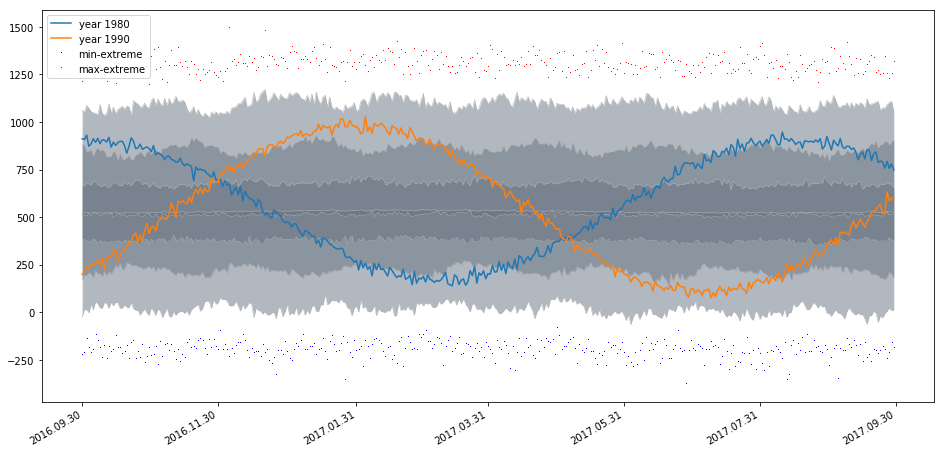

In [3]:
# demo partition_by and percentiles function

utc = Calendar()
t0 = utc.time(1930, 9, 1)
dt = deltahours(1)
n = utc.diff_units(t0, utc.time(2016, 9, 1), dt)

ta = TimeAxis(t0, dt, n)

# just generate some data that is alive
x = np.linspace(start=0.0,stop=np.pi*200,num=len(ta))

pattern_values = DoubleVector.from_numpy(500.0 + x*np.sin(x)+x/10+ 1000.0*np.random.normal(0,0.1,len(ta))) # increasing values

src_ts = TimeSeries(ta=ta, values=pattern_values, point_fx=fx_policy.POINT_AVERAGE_VALUE)

partition_t0 = utc.time(2016, 9, 1) # we want our percentiles to align to this particular time, for presentation
n_partitions = 80
partition_interval = Calendar.YEAR

# call .partition_by that does the magic of aligning using the time_shift function
# returns TsVector,
# where all TsVector[i].index_of(partition_t0)
# is equal to the index ix for which the TsVector[i].value(ix) 
# correspond to start value of that particular partition.
#  in short: moves the years to a common start-point that you specify, utilizing the time_shift function
#            still-keeping a reference to the underlying time-series (no copy occurs, just mirroring)
#
ts_partitions = src_ts.partition_by(utc, t0, partition_interval, n_partitions, partition_t0)


# Now finally, try percentiles on the partitions that have the proper ts-vector size

wanted_percentiles = [stat_p.MIN_EXTREME, 0, 10, 25, stat_p.AVERAGE, 50, 75, 90, 100,stat_p.MAX_EXTREME] 

t0_view = utc.add(partition_t0,Calendar.MONTH,1) # note to Eli; this is how we can present one year from 1.10
ta_percentiles = TimeAxis(t0_view, deltahours(24), 365) # this is the time-axis that we want aggregate on, day-average
p_result = percentiles(ts_partitions,ta_percentiles,wanted_percentiles)

# finally some plot, including one particular year (note the .average trick)
common_timestamps = [datetime.datetime.utcfromtimestamp(p.start) for p in ta_percentiles]
fig,ax=plt.subplots(figsize=(16,8))
splt.set_calendar_formatter(utc)
h,ph=splt.plot_np_percentiles(common_timestamps,[p.values.to_numpy() for p in p_result[1:-1]],base_color=(0.4,0.45,0.5))

plt.plot(common_timestamps,ts_partitions[50].average(ta_percentiles).values.to_numpy(), label='year 1980') # note the .average trick here
plt.plot(common_timestamps,ts_partitions[60].average(ta_percentiles).values.to_numpy(), label='year 1990')
plt.plot(common_timestamps,p_result[0].values.to_numpy(),'b,',label='min-extreme')
plt.plot(common_timestamps,p_result[-1].values.to_numpy(),'r,',label='max-extreme')

plt.legend()

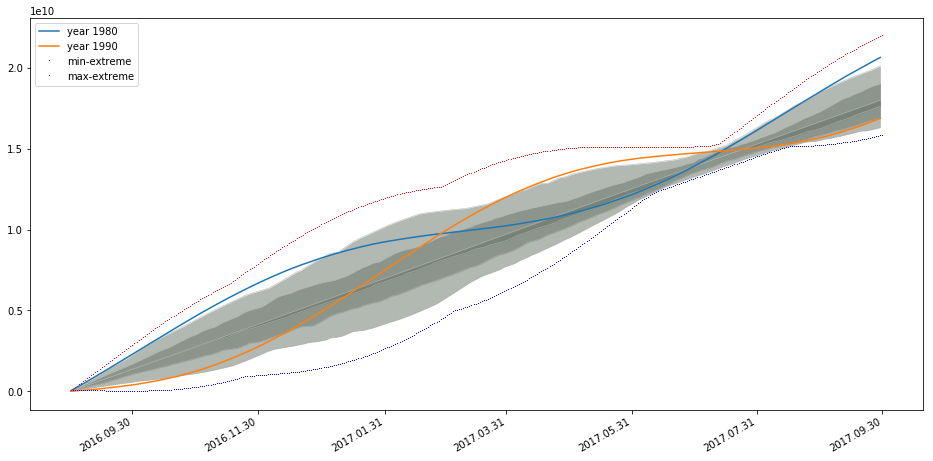

In [4]:
# Ok, this was fun!
#, now let's compute the accumulated yearly signals, starting from 1.9
ts_acc_partitions = TsVector() # collect the acc stuff here, so we can do percentiles afterwards
ta_accumulate = TimeAxis(partition_t0,deltahours(24),365+31) # accumulate from 1.9 + 1 + year and one month
for ts in ts_partitions:
    ts_acc_partitions.append( ts.accumulate(ta_accumulate))

acc_wanted_percentiles = [stat_p.MIN_EXTREME, 10, 25, stat_p.AVERAGE, 50, 75, 90,stat_p.MAX_EXTREME] 

p_acc_result = percentiles(ts_acc_partitions,ta_accumulate,acc_wanted_percentiles)

#then just plot it out, again, we plot from 1.10, even if we aligne to 1.9 re-using ta_percentiles from above
common_timestamps = [datetime.datetime.utcfromtimestamp(p.start) for p in ta_accumulate]

fig,ax=plt.subplots(figsize=(16,8))
splt.set_calendar_formatter(utc)
h,ph=splt.plot_np_percentiles(common_timestamps,[p.values.to_numpy() for p in p_acc_result[1:-1]],base_color=(0.4,0.45,0.4))

plt.plot(common_timestamps,ts_acc_partitions[50].average(ta_accumulate).values.to_numpy(), label='year 1980') # note the .average trick here
plt.plot(common_timestamps,ts_acc_partitions[60].average(ta_accumulate).values.to_numpy(), label='year 1990')
plt.plot(common_timestamps,p_acc_result[0].values.to_numpy(),'b,',label='min-extreme')
plt.plot(common_timestamps,p_acc_result[-1].values.to_numpy(),'r,',label='max-extreme')

plt.legend(loc=2)
    